In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri
from matplotlib.pyplot import rc_context

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/anaconda3/envs/singlecell/lib/R/library/")

library(clustree)



In [4]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
adata = sc.read_h5ad("/mnt/lugli/spuccio/SP028_Autoimmunity/Cariplo/IBD_counts/h5files/CD4_after_DESC_dirty.h5ad")

In [6]:
adata2 =sc.read_h5ad("/mnt/lugli/spuccio/SP028_Autoimmunity/Cariplo/IBD_counts/h5files/CD4_after_DESC_clean.h5ad")

In [7]:
adata = adata[adata.obs.index.isin(adata[adata.obs['desc_0.6'].isin([0,1,3,4,5,7,9]),:].obs.index),:]

In [8]:
adata2 = adata2[adata2.obs.index.isin(adata2[adata2.obs['desc_0.6'].isin([0,1,3,4,5,7,9]),:].obs.index),:]

In [10]:
adata.obs['desc_0.6'].unique()

[9, 4, 7, 0, 1, 5, 3]
Categories (7, int64): [9, 4, 7, 0, 1, 5, 3]

In [13]:
new_cluster_names = [
    '0', '1','2','3','4','5','6']
adata.rename_categories('desc_0.6', new_cluster_names)

In [15]:
new_cluster_names = [
    '0', '1','2','3','4','5','6']
adata2.rename_categories('desc_0.6', new_cluster_names)

Trying to set attribute `.uns` of view, copying.


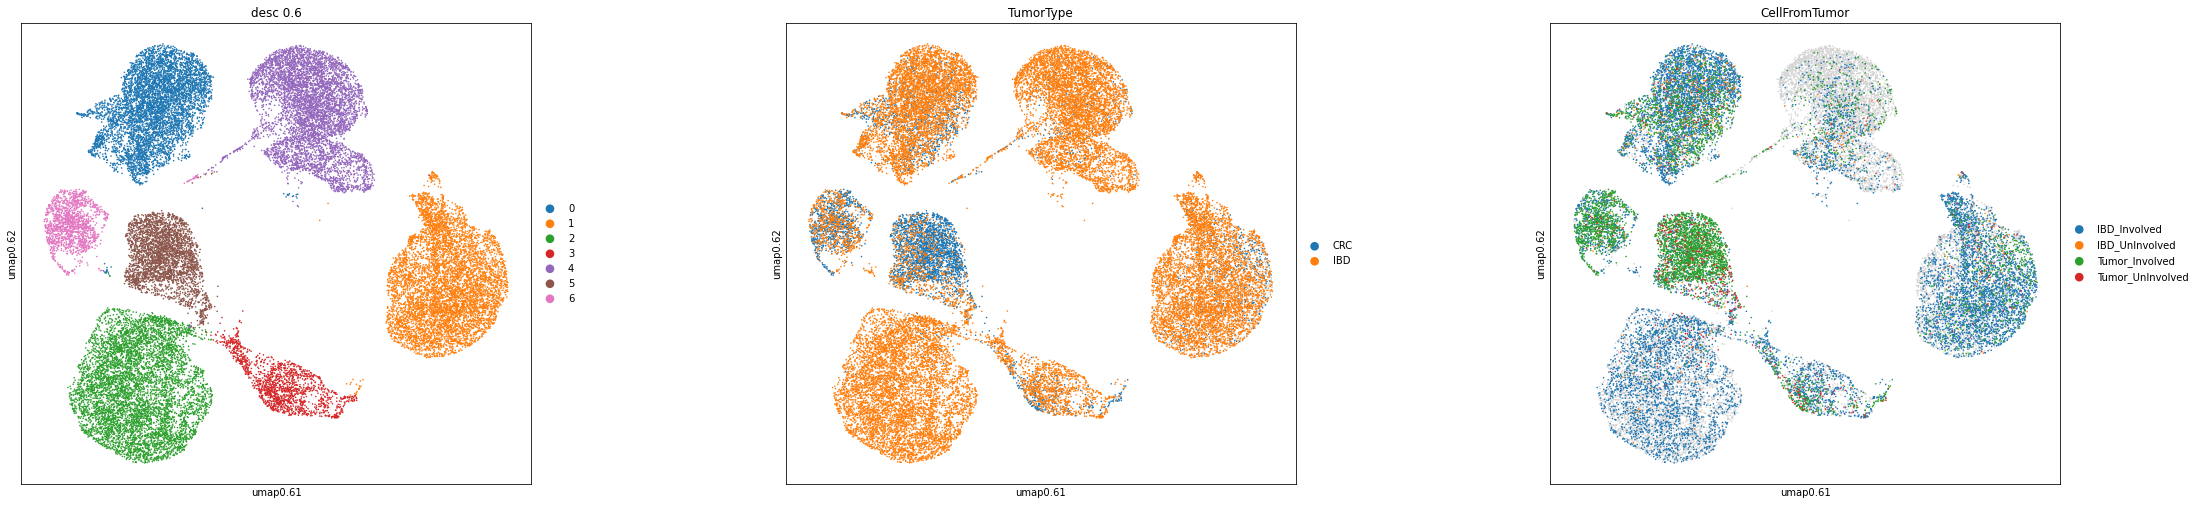

In [17]:
plt.rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata,basis="umap0.6",color=['desc_0.6',"TumorType",'CellFromTumor'],size=10)

In [18]:
adata2

View of AnnData object with n_obs × n_vars = 31258 × 16323
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'dataset', 'batch', 'percent_mt2', 'n_counts', 'n_genes', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.8'
    obsm: 'X_Embeded_z0.4', 'X_Embeded_z0.5', 'X_Embeded_z0.6', 'X_Embeded_z0.8', 'X_umap', 'X_umap0.4', 'X_umap0.5', 'X_umap0.6', 'X_umap0.8'

In [19]:
adata

AnnData object with n_obs × n_vars = 31258 × 2248
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'dataset', 'batch', 'percent_mt2', 'n_counts', 'n_genes', 'desc_0.4', 'desc_0.5', 'desc_0.6', 'desc_0.8'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'prob_matrix0.4', 'prob_matrix0.5', 'prob_matrix0.6', 'prob_matrix0.8', 'umap', 'desc_0.6_colors', 'TumorType_colors', 'CellFromTumor_colors'
    obsm: 'X_Embeded_z0.4', 'X_Embeded_z0.5', 'X_Embeded_z0.6', 'X_Embeded_z0.8', 'X_umap', 'X_umap0.4', 'X_umap0.5', 'X_umap0.6', 'X_umap0.8'
    obsp: 'connectivities', 'distances'

In [20]:
adata.raw =  adata

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [22]:
sc.pp.log1p(adata)

/home/spuccio/anaconda3/envs/singlecell/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:354: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [23]:
sc.pp.scale(adata, max_value=3,zero_center=True)

In [24]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb')
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

In [25]:
adata2.obsm['X_emb'] = adata2.obsm['X_Embeded_z'+str(0.6)]
run_vis(adata2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


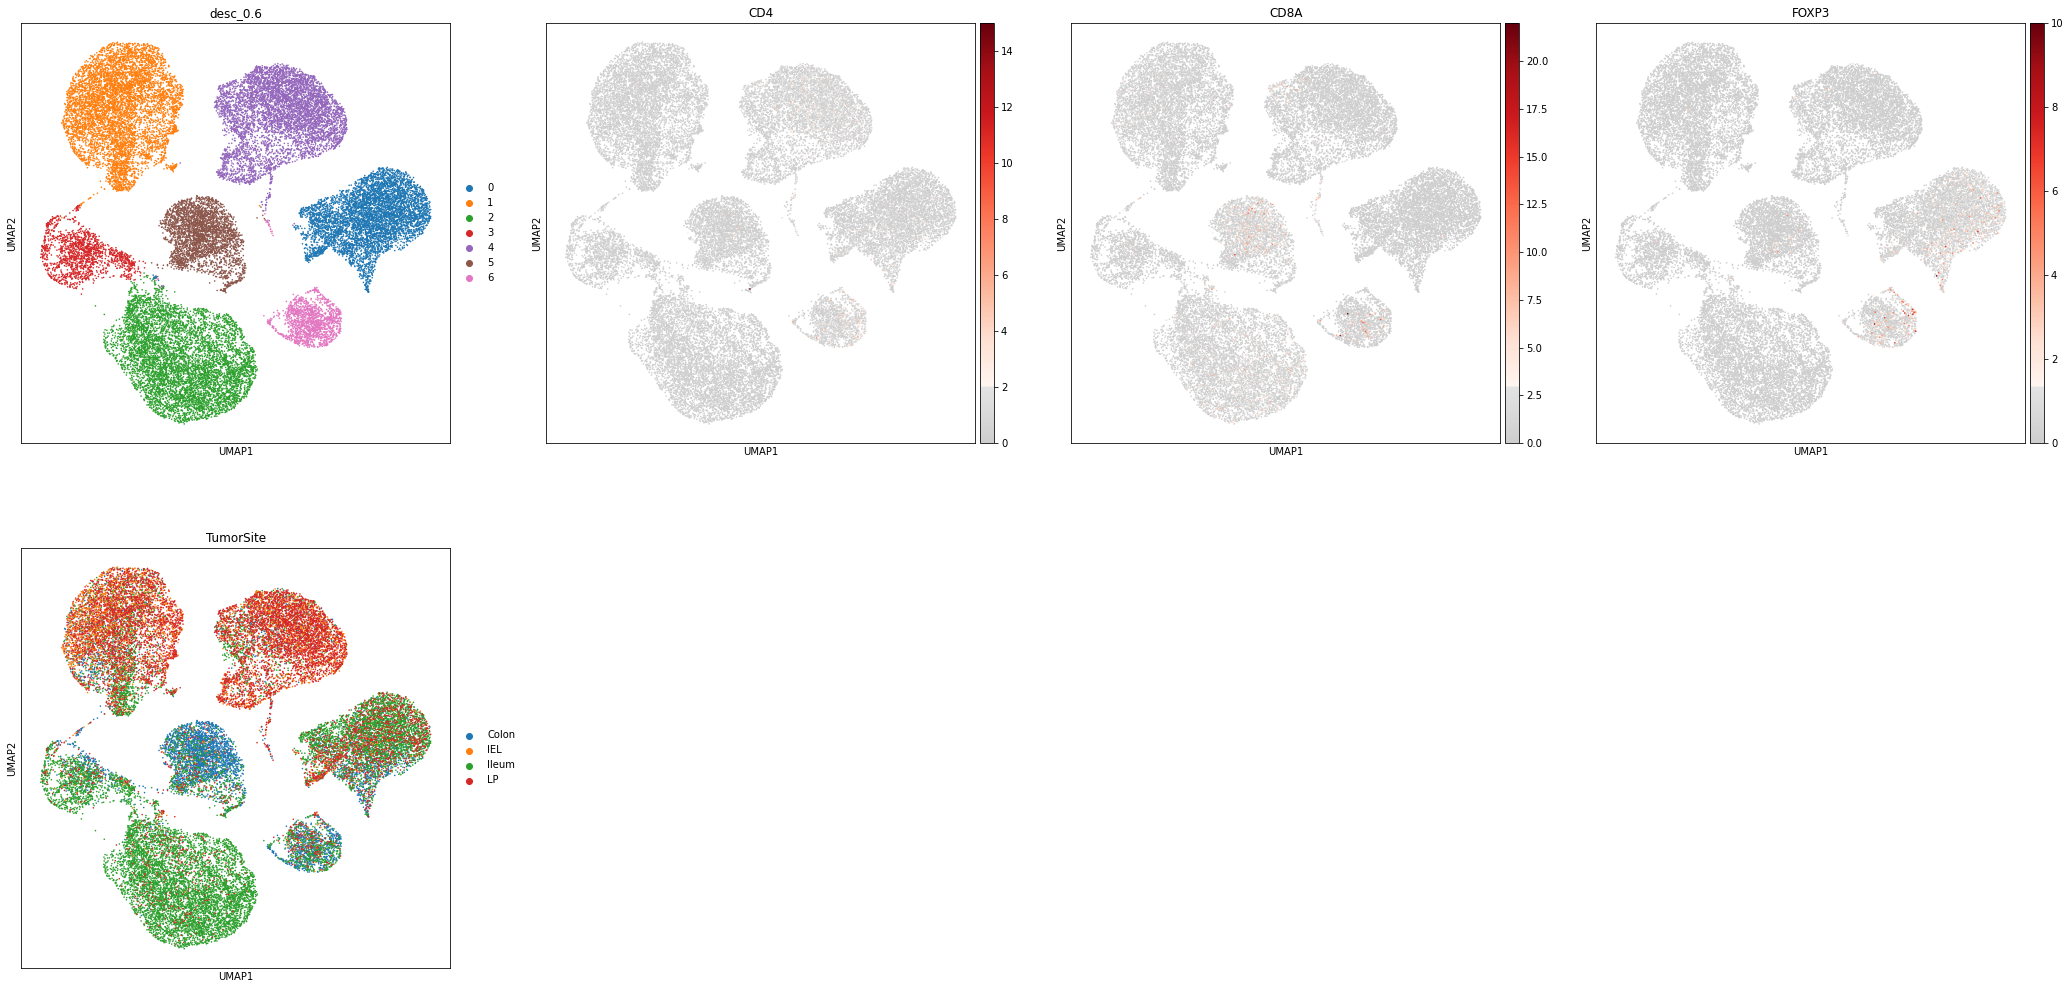

In [26]:
sc.pl.umap(adata2, color=['desc_0.6','CD4','CD8A','FOXP3','TumorSite'],s=10,color_map=mymap)


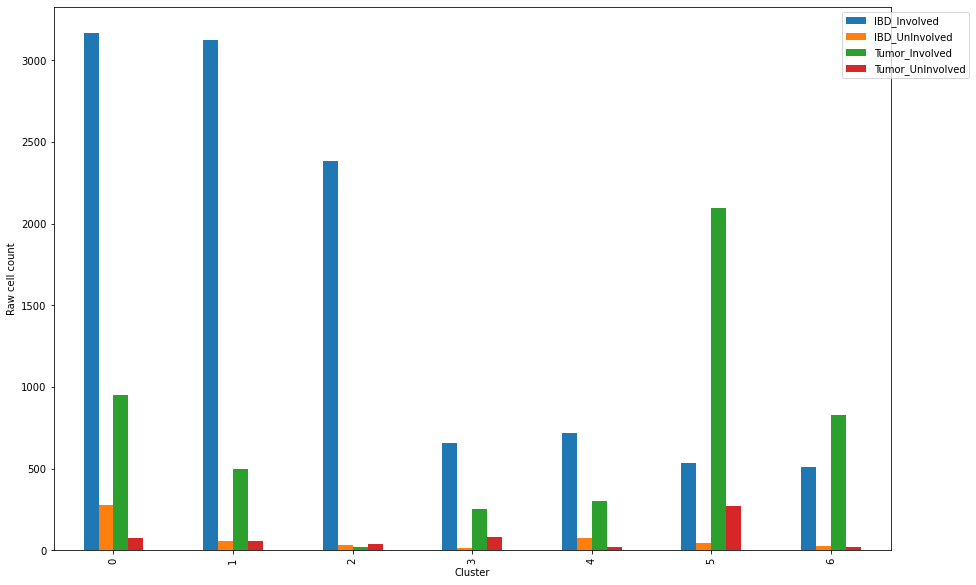

In [27]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,10))
#
ax1 = pd.crosstab(adata2.obs["desc_0.6"], adata2.obs.CellFromTumor).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Raw cell count")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

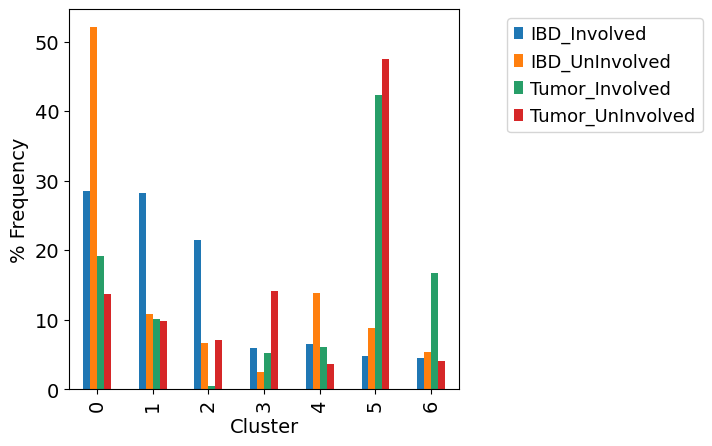

In [43]:
fig, (ax1) = plt.subplots(1,1, figsize=(5,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.6"], adata.obs.CellFromTumor,normalize="columns")*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

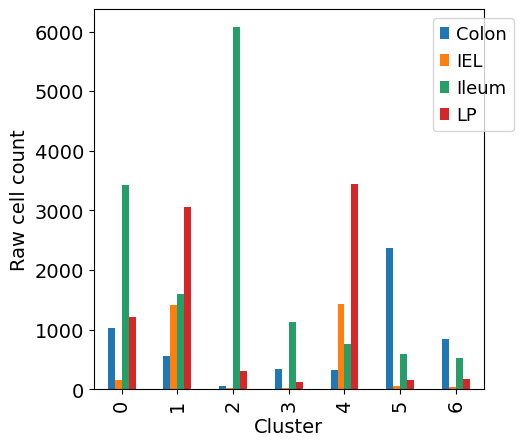

In [44]:
fig, (ax1) = plt.subplots(1,1, figsize=(5,5))
#
ax1 = (pd.crosstab(adata.obs["desc_0.6"], adata.obs.TumorSite,normalize=False)).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Raw cell count")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

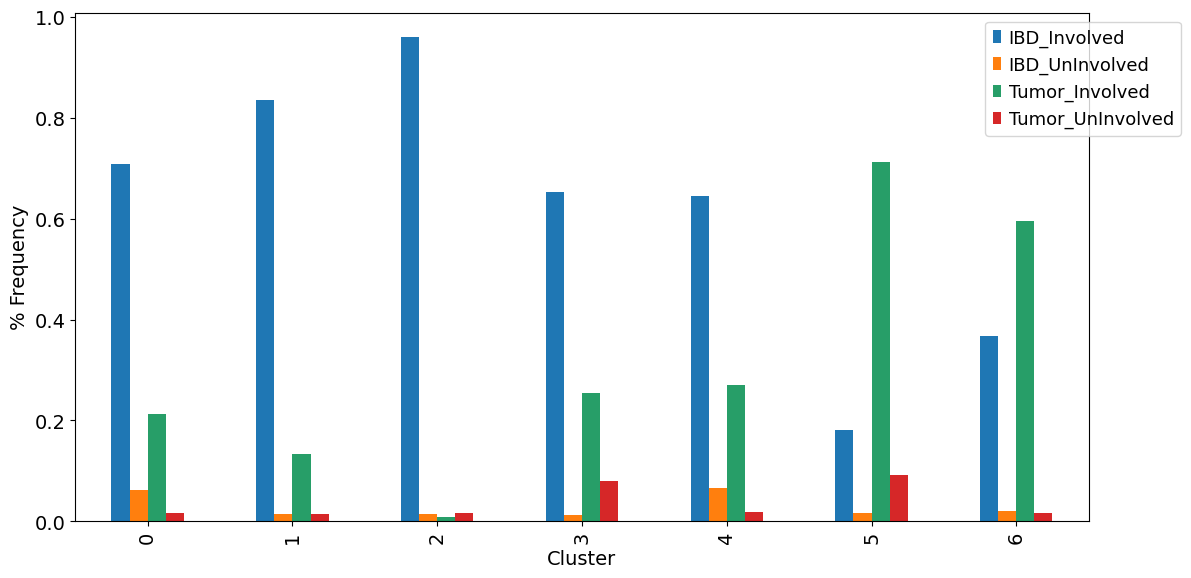

In [45]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.6")["CellFromTumor"].value_counts(normalize=True).unstack().plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

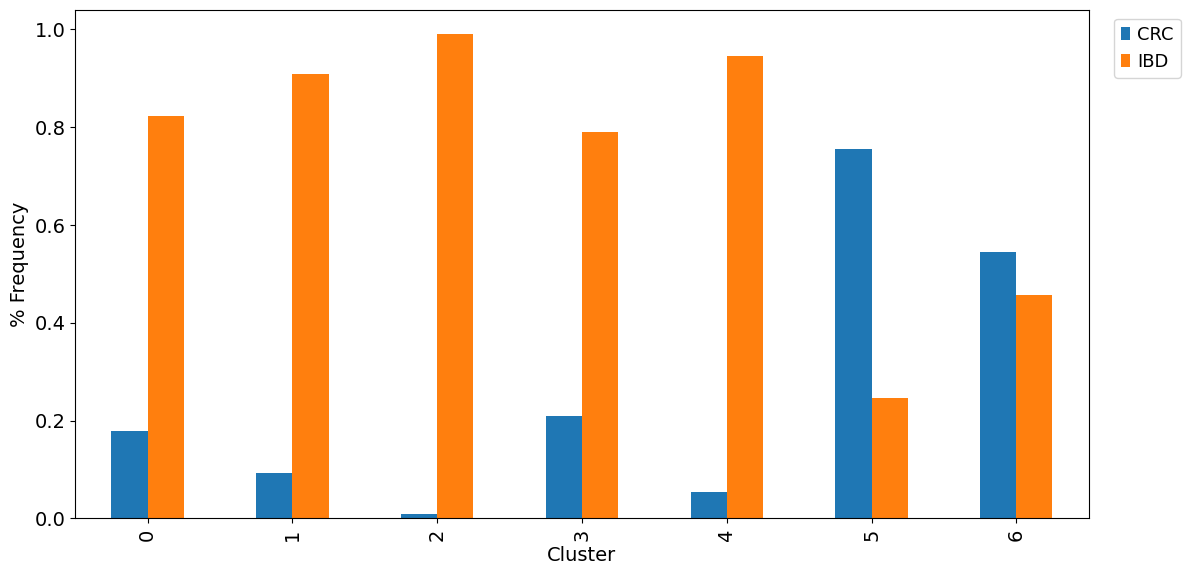

In [46]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.6")["TumorType"].value_counts(normalize=True).unstack().plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [47]:
adata.obs['desc_0.6'].value_counts()

1    6633
2    6459
4    5955
0    5836
5    3178
3    1614
6    1583
Name: desc_0.6, dtype: int64

In [33]:
#adata.raw = adata

rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata, color=['desc_0.6'],color_map=mymap, add_outline=True,
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells')

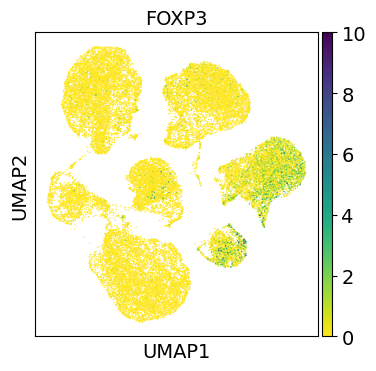

In [48]:
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata2, color=['FOXP3'])

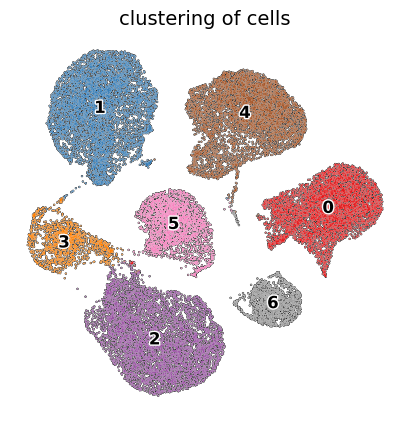

In [50]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata2, color=['desc_0.6'], add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')

In [76]:
#adata2.obs[['CellFromTumor']].describe()

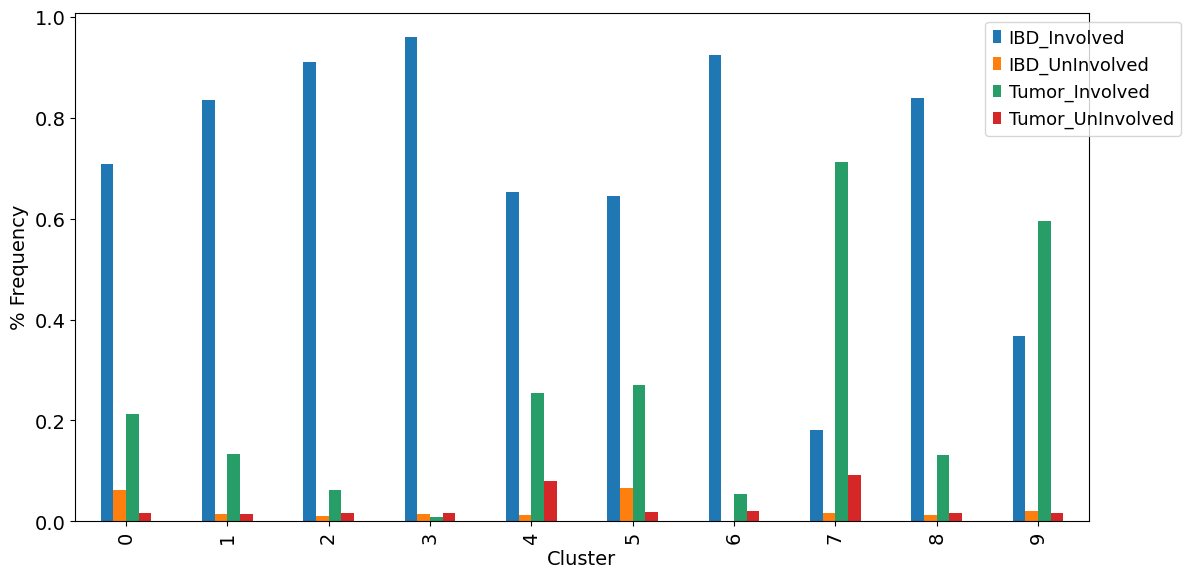

In [77]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata2.obs.groupby("desc_0.6")["CellFromTumor"].value_counts(normalize=True).unstack().plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

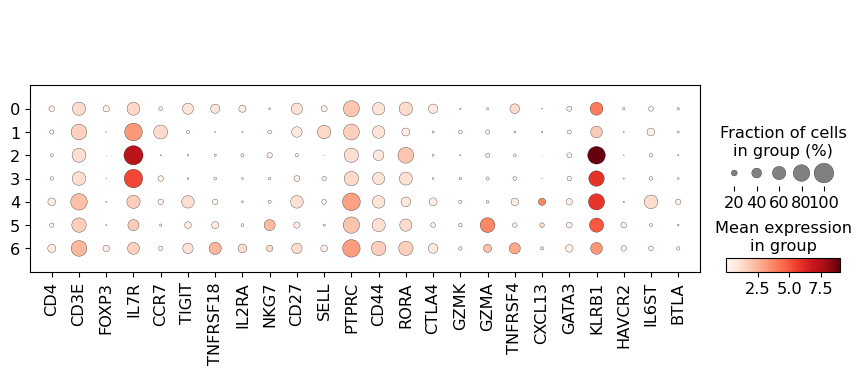

In [53]:
sc.pl.dotplot(adata2, ['CD4','CD3E','FOXP3','IL7R','CCR7','TIGIT','TNFRSF18','IL2RA','NKG7','CD27','SELL','PTPRC','CD44','RORA','CTLA4','GZMK','GZMA','TNFRSF4','CXCL13','GATA3','KLRB1','HAVCR2','IL6ST','BTLA'], groupby='desc_0.6');

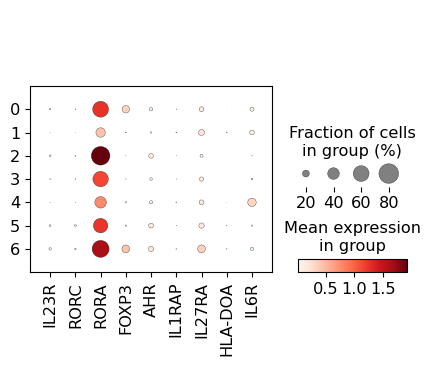

In [54]:
sc.pl.dotplot(adata2, ['IL23R','RORC','RORA','FOXP3','AHR','IL1RAP','IL27RA','HLA-DOA','IL6R'], groupby='desc_0.6');

In [ ]:
IL23R;RORC;RORA;AHR;IL1RAP;IL27RA;HLA-DOA;HLA-DOB;IL6R;IL4R;IL1R1;FOXP3;RUNX1;IL23A;PRKCQ;IL6ST;GATA3;HIF1A;PPP3R1;PLCG1;HLA-DQA2;HLA-DQA1;SMAD2;STAT5A;STAT5B;HLA-DRB5;JUN;SMAD4;SMAD3;TGFB1;NFATC3;NFATC2;NFATC1;IL2;NFKB1;IL4;NFKBIA;IL6;HLA-DRA;NFKBIE;HLA-DRB1;LAT;NFKBIB;IL21;IL22;HSP90AB1;CD3G;CD3E;CD3D;IKBKB;PPP3CA;PPP3CB;PPP3CC;IKBKG;JAK2;JAK3;HLA-DPA1;JAK1;HSP90AA1;CHUK;IFNGR1;IFNGR2;FOS;TYK2;TGFBR1;TGFBR2;ZAP70;IFNG;IRF4;LCK;IL1B;RARA;HLA-DQB1;IL2RG;RELA;RXRB;MAPK9;HLA-DMA;MAPK8;HLA-DMB;RXRA;TBX21;IL21R;MAPK1;STAT6;IL12RB1;RXRG;MAPK3;STAT1;STAT3;MAPK14;MAPK12;MAPK13;MAPK10;MAPK11;CD4;IL2RA;IL2RB;HLA-DPB1;IL17F;CD247;IL17D;IL17A

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


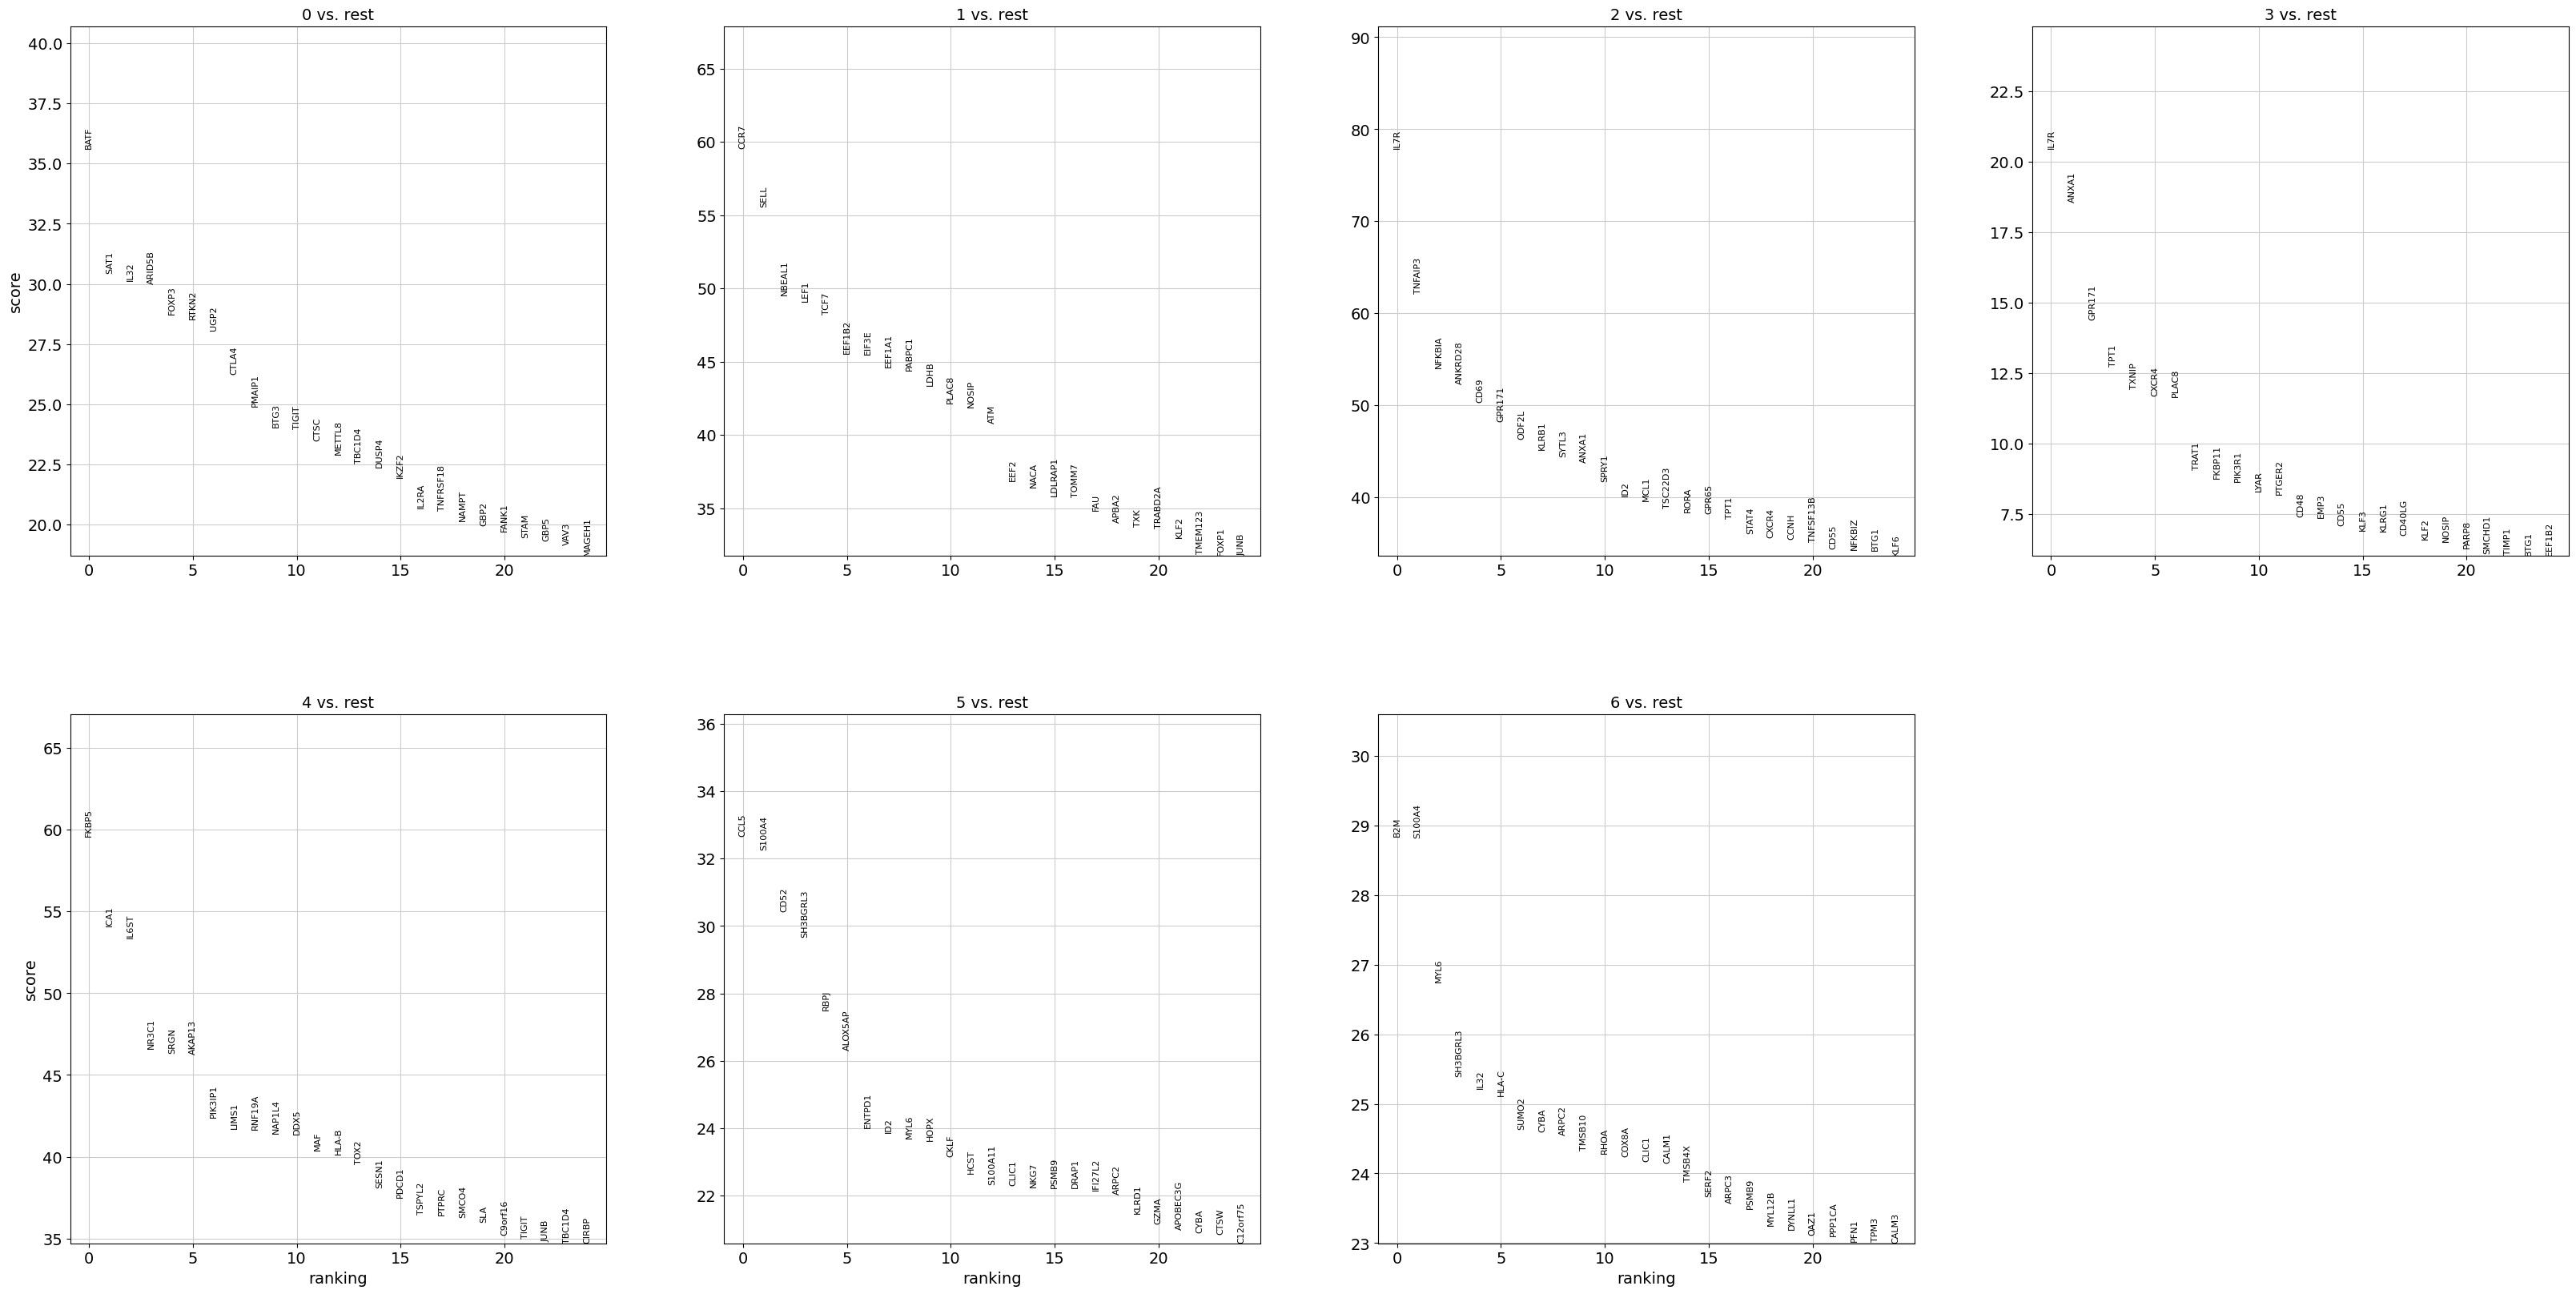

In [55]:
sc.tl.rank_genes_groups(adata2, 'desc_0.6', method='t-test',use_raw=True)
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)

In [56]:
result = adata2.uns['rank_genes_groups']

In [57]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
    for group in groups for key in ['names','pvals','pvals_adj','logfoldchanges']}).to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/Cariplo/CD4_res06_DEGS.csv",header=True,index=False)

In [58]:
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(20)

,0,1,2,3,4,5,6
0,BATF,CCR7,IL7R,IL7R,FKBP5,CCL5,B2M
1,SAT1,SELL,TNFAIP3,ANXA1,ICA1,S100A4,S100A4
2,IL32,NBEAL1,NFKBIA,GPR171,IL6ST,CD52,MYL6
3,ARID5B,LEF1,ANKRD28,TPT1,NR3C1,SH3BGRL3,SH3BGRL3
4,FOXP3,TCF7,CD69,TXNIP,SRGN,RBPJ,IL32
5,RTKN2,EEF1B2,GPR171,CXCR4,AKAP13,ALOX5AP,HLA-C
6,UGP2,EIF3E,ODF2L,PLAC8,PIK3IP1,ENTPD1,SUMO2
7,CTLA4,EEF1A1,KLRB1,TRAT1,LIMS1,ID2,CYBA
8,PMAIP1,PABPC1,SYTL3,FKBP11,RNF19A,MYL6,ARPC2
9,BTG3,LDHB,ANXA1,PIK3R1,NAP1L4,HOPX,TMSB10


In [59]:
adata.write("/mnt/lugli/spuccio/SP028_Autoimmunity/Cariplo/IBD_counts/h5files/CD4_clean.h5ad")

In [93]:
result = adata2.uns['rank_genes_groups']

In [94]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:]: result[key][group]
    for group in groups for key in ['names','pvals','pvals_adj','logfoldchanges']}).to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/Cariplo/CD4_res06_DEGS_pcs10.csv",header=True,index=False)

In [95]:
adata2.write("/mnt/lugli/spuccio/SP028_Autoimmunity/Cariplo/IBD_counts/h5files/DESC_marker_genes.h5ad")

In [97]:
#sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, values_to_plot='logfoldchanges',  vmax=3, vmin=-3, cmap='bwr')

In [98]:
#sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, values_to_plot='logfoldchanges',  vmax=3, vmin=-3, cmap='bwr',groups=["3","4"])

In [99]:
#sc.pl.rank_genes_groups_matrixplot(adata, n_genes=10, use_raw=False, vmin=-1, vmax=1, cmap='bwr')

In [100]:
#sc.pl.matrixplot(adata, marker_genes_dict, 'clusters', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')